# Globals

In [1]:
import pandas as pd
import numpy as np
import yaml
import glob
import os
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

# Parse paths to make pp calls

In [2]:
paths_path = '/juno/work/shah/users/chois7/metacohort/paths.WGS-REMIXT-POSTPROCESS.tsv'
paths = pd.read_table(paths_path)
# paths = paths[paths['isabl_sample_id'].isin(sean_samples)]
metas = paths[paths['result_type']=='meta'][['isabl_sample_id', 'result_filepath']]
meta_paths = dict(zip(metas['isabl_sample_id'], metas['result_filepath']))

In [4]:
sample_id = 'DAH123a'

In [13]:
paths_path = '/juno/work/shah/users/chois7/metacohort/paths.WGS-REMIXT-POSTPROCESS.tsv'
paths = pd.read_table(paths_path)
paths = paths[paths['isabl_sample_id']==sample_id]
metas = paths[paths['result_type']=='meta'][['isabl_sample_id', 'result_filepath']]
meta_paths = dict(zip(metas['isabl_sample_id'], metas['result_filepath']))
assert len(meta_paths) == 1, meta_paths
sample2pp = {}
for sample_id, meta_path in meta_paths.items():
    meta = yaml.load(open(meta_path))
    purity = sum(meta['mix'][1:])
    ploidy = meta['ploidy']
    sample2pp[sample_id] = (ploidy, purity)
    print(f'{sample_id} {ploidy} {purity}')

DAH123a 2.002504986947994 0.8523343047143509


/home/chois7/chois7/envs/p37/lib/python3.7/site-packages/ipykernel_launcher.py:9: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  if __name__ == "__main__":


# Plot WGD status

In [31]:
def calculate_wgd_status(df:pd.DataFrame) -> pd.Series:
    """ return WGD status based on LOH (fraction) and Ploidy
    """
    wgd_status = ((2.8 - (1.1/0.85) * df['LOH']) < df['Ploidy'])# -(1.1/0.85) * LOH + 2.8 < Ploidy
    return wgd_status

## parse WGD status tsv

In [5]:
samples_path = '/juno/work/shah/users/chois7/spectrum/calc_wgd/resources/n386.txt'
samples = [x.strip() for x in open(samples_path, 'r').readlines()]

In [6]:
results_path = '/juno/work/shah/users/chois7/spectrum/calc_wgd/v1/results'

In [7]:
df = pd.DataFrame()
for sample in samples:
    wgd_path = f'{results_path}/{sample}/{sample}.wgd.tsv'
    if not os.path.exists(wgd_path): continue
    wgd = pd.read_table(wgd_path)
    wgd.index = [sample]
    df = pd.concat([df, wgd])

## parse PCAWG

In [38]:
pcawg_path = '/juno/work/shah/users/mcphera1/repos/spectrumanalysis/external/pcawg_cnv/ploidy_loh.csv.gz'
pcawg = pd.read_csv(pcawg_path)
pcawg.rename(columns={'loh': 'LOH', 'ploidy':'Ploidy'}, inplace=True)
pcawg.set_index('sample', inplace=True)
wgd_status = calculate_wgd_status(pcawg)

## QC

In [32]:
# wgd_status = ((2.9 - 2 * df['LOH']) <= df['Ploidy'])# 2.9 -2*hom <= ploidy
# wgd_status = ((2.8 - (1.1/0.85) * df['LOH']) < df['Ploidy'])# -(1.1/0.85) * LOH + 2.8 < Ploidy
wgd_status = calculate_wgd_status(df)

In [145]:
# (wgd_status != df['WGD']).sum()

In [35]:
df['WGD'] = wgd_status

## plot

In [109]:
# line_x = np.linspace(0.02, 0.78, 50)
line_x = np.linspace(0.01, 0.95, 50)

In [110]:
line_y = 2.8 - (1.1/0.85) * line_x

### n=170

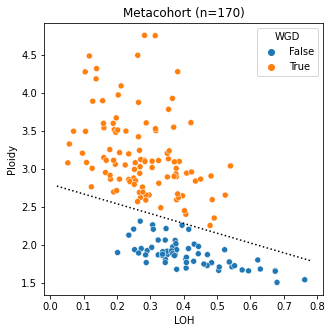

In [151]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(5)
sns.scatterplot(data=df, x='LOH', y='Ploidy', hue='WGD', ax=ax)
ax.plot(line_x, line_y, "k:")#color='grey', linestyle='--')
ax.set_xlabel('LOH');
ax.set_title('Metacohort (n=170)');

### n=386

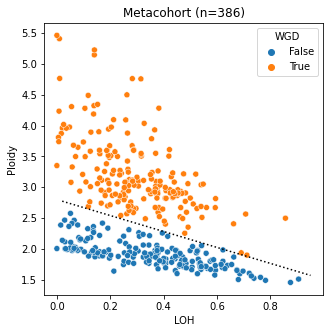

In [107]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(5)
sns.scatterplot(data=df, x='LOH', y='Ploidy', hue='WGD', ax=ax)
ax.plot(line_x, line_y, "k:")#color='grey', linestyle='--')
ax.set_xlabel('LOH');
ax.set_title(f'Metacohort (n={df.shape[0]})');

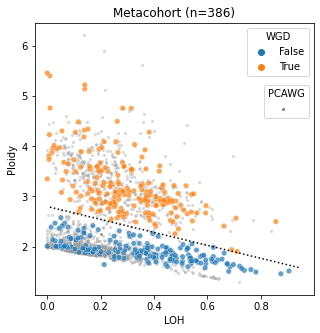

In [111]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(5)
p1 = sns.scatterplot(data=pcawg, x='LOH', y='Ploidy', color='grey', alpha=0.3, ax=ax, s=10)
p2 = sns.scatterplot(data=df, x='LOH', y='Ploidy', hue='WGD', ax=ax, alpha=0.7, s=30)
ax.plot(line_x, line_y, "k:")#color='grey', linestyle='--')
ax.set_xlabel('LOH');
ax.set_title(f'Metacohort (n={df.shape[0]})');

leg = ax.legend(title="WGD")
ax.add_artist(leg)
h = [plt.plot([],[], color="gray", marker="o", ms=2, ls="")[0]]
plt.legend(handles=h, labels=[''], title="PCAWG", loc=(0.823,0.65))

# add signature labels

## Metacohort WGS

### use Tyler's labels

In [13]:
conv_df = pd.read_table('~/tables/ov-tnbc_labels_post_SHAH-3783.tsv')
strata_path = '/juno/work/shah/users/chois7/metacohort/mmctm/resources/Tyler_2022_Nature_labels.tsv'
output_path = '/juno/work/shah/users/chois7/metacohort/mmctm/resources/Tyler_2022_Nature_labels.isabl.tsv'
strata = pd.read_table(strata_path)[['sample_id', 'signature_stratum']]
tyler2isabl = conv_df.set_index('sample_id').to_dict()['isabl_sample_id']
strata['isabl_sample_id'] = strata['sample_id'].map(tyler2isabl)
strata[['isabl_sample_id', 'sample_id', 'signature_stratum']].rename(
    columns={'sample_id':'tyler_sample_id', 'signature_stratum':'curated'}).to_csv(output_path, sep='\t', index=False)
strata = strata.rename(columns={'signature_stratum':'curated'})

In [187]:
# sig_path = '/juno/work/shah/users/chois7/spectrum/calc_wgd/resources/signature_labels.tsv'
# sig = pd.read_table(sig_path)

In [14]:
sig = df.join(strata.set_index('isabl_sample_id')[['curated']]).dropna()
sig.rename(columns={'curated':'curated label'}, inplace=True)

In [15]:
labels = ['FBI', 'HRD-Dup', 'HRD-Del', 'TD']

#### n=170

FBI (68, 4) #753924
HRD-Del (30, 4) #6B9E6E
HRD-Dup (54, 4) #658FB3
TD (18, 4) #FF6666


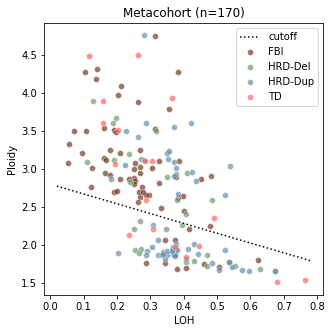

In [191]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(5)
colors = {'FBI':'#753924',
          'HRD-Dup':'#658FB3',
          'HRD-Del':'#6B9E6E',
          'TD':'#FF6666',}
for label, subdf in sig.groupby('curated label'):
    color = colors[label]
    print(label, subdf.shape, color)
    sns.scatterplot(data=subdf, x='LOH', y='Ploidy', color=color, alpha=0.7, ax=ax, label=label)
ax.plot(line_x, line_y, 'k:')
ax.set_xlabel('LOH');
ax.set_title('Metacohort (n=170)');
legend_order = ['cutoff', 'FBI', 'HRD-Del', 'HRD-Dup', 'TD']
legend = ax.legend(legend_order)

#### n=386

FBI (135, 4) #753924
HRD-Del (43, 4) #6B9E6E
HRD-Dup (110, 4) #658FB3
TD (21, 4) #FF6666


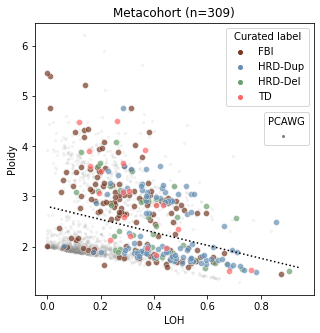

In [112]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(5)
p1 = sns.scatterplot(data=pcawg, x='LOH', y='Ploidy', color='grey', alpha=0.1, ax=ax, s=10)
colors = {'FBI':'#753924',
          'HRD-Dup':'#658FB3',
          'HRD-Del':'#6B9E6E',
          'TD':'#FF6666',}
for label, subdf in sig.groupby('curated label'):
    color = colors[label]
    print(label, subdf.shape, color)
    sns.scatterplot(data=subdf, x='LOH', y='Ploidy', color=color, alpha=0.7, ax=ax)
ax.plot(line_x, line_y, 'k:')
ax.set_xlabel('LOH');
ax.set_title(f'Metacohort (n={sig.shape[0]})');
legend_order = ['cutoff', 'FBI', 'HRD-Del', 'HRD-Dup', 'TD']
legend = ax.legend(legend_order)

h_label = [plt.plot([], [], color=colors[label], marker="o", ms=4, ls="")[0] for label in colors]
leg = ax.legend(handles=h_label, labels=colors.keys(), title="Curated label")
ax.add_artist(leg)
h_pcawg = [plt.plot([],[], color="gray", marker="o", ms=2, ls="")[0]]
plt.legend(handles=h_pcawg, labels=[''], title="PCAWG", loc=(0.823,0.55))

### calculate fraction

In [192]:
sig['curated label'].value_counts()

FBI        68
HRD-Dup    54
HRD-Del    30
TD         18
Name: curated label, dtype: int64

In [17]:
sig['curated label'].value_counts()

FBI        135
HRD-Dup    110
HRD-Del     43
TD          21
Name: curated label, dtype: int64

In [18]:
all_wgd = sig['WGD'].sum()
all_wgd_frac = all_wgd / sig.shape[0]
frac = pd.DataFrame(columns=['signature group', 'WGD fraction', 'WGD (real)', 'WGD (expected)'])
for ix, label in enumerate(labels):
    subdf = sig[sig['curated label'] == label]
    sig_count = subdf.shape[0]
    wgd_expected = round(all_wgd_frac * sig_count, 1)
    wgd_count = subdf['WGD'].sum()
    wgs_frac = wgd_count / sig_count
    field = [label, wgs_frac, wgd_count, wgd_expected]
    frac.loc[ix] = field

In [197]:
frac

,signature group,WGD fraction,WGD (real),WGD (expected)
0,FBI,0.838235,57,41.0
1,HRD-Dup,0.370370,20,33.0
2,HRD-Del,0.500000,15,18.0
3,TD,0.611111,11,11.0


In [ ]:
obs = frac['WGD (real)'].values
exp = frac['WGD (expected)'].values
length = len(obs)
scipy.stats.chisquare(obs, exp)

Power_divergenceResult(statistic=10.150220609836847, pvalue=0.017331431338075794)

In [20]:
frac

,signature group,WGD fraction,WGD (real),WGD (expected)
0,FBI,0.674074,91,73.8
1,HRD-Dup,0.381818,42,60.2
2,HRD-Del,0.511628,22,23.5
3,TD,0.666667,14,11.5


In [ ]:
obs = frac['WGD (real)'].values
exp = frac['WGD (expected)'].values
length = len(obs)
scipy.stats.chisquare(obs, exp)

Power_divergenceResult(statistic=10.150220609836847, pvalue=0.017331431338075794)

## violin plot for the ploidy

In [206]:
sig.head()

,LOH,Ploidy,WGD,curated label
SA505244,0.323516,2.062922,False,HRD-Dup
SA505270,0.485395,2.595106,True,HRD-Del
SA505282,0.165640,2.953009,True,FBI
SA505297,0.575178,1.668616,False,HRD-Dup
SA505328,0.272643,1.950251,False,HRD-Del


Text(0.5, 1.0, 'Metacohort (n=170)')

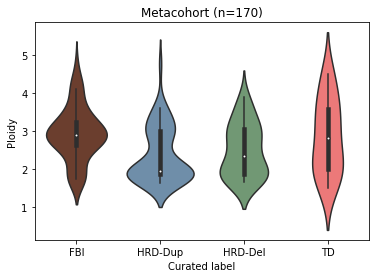

In [211]:
# Create a sample dataset
data = sns.load_dataset('tips')

# Draw a violin plot
sns.violinplot(x='curated label', y='Ploidy', data=sig,
               order=labels, palette=[colors[x] for x in labels])

# Add labels and title
plt.xlabel('Curated label')
plt.ylabel('Ploidy')
plt.title('Metacohort (n=170)')

Text(0.5, 1.0, 'Metacohort (n=309)')

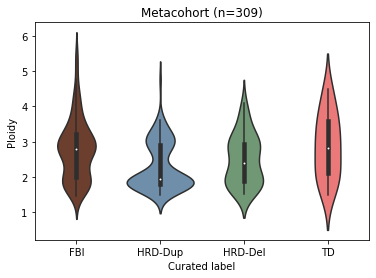

In [21]:
# Create a sample dataset
data = sns.load_dataset('tips')

# Draw a violin plot
sns.violinplot(x='curated label', y='Ploidy', data=sig,
               order=labels, palette=[colors[x] for x in labels])

# Add labels and title
plt.xlabel('Curated label')
plt.ylabel('Ploidy')
plt.title(f'Metacohort (n={sig.shape[0]})')

### facet violin by BRCA1 status: HRD-Dup only

In [22]:
mut_path = '/juno/work/shah/users/chois7/metacohort/mmctm/results/analysis/labels/pathogenic.tsv'
mut = pd.read_table(mut_path)

In [23]:
brca1 = mut[['isabl_sample_id', 'BRCA1']].set_index('isabl_sample_id')
msig = sig.join(brca1).dropna() # sig with mutation

In [24]:
msig.loc[(msig['BRCA1'] & (msig['curated label']=='HRD-Dup')), 'curated label'] += ':BRCA1'

In [25]:
msig['curated label'].value_counts()

FBI              135
HRD-Dup           75
HRD-Del           43
HRD-Dup:BRCA1     35
TD                21
Name: curated label, dtype: int64

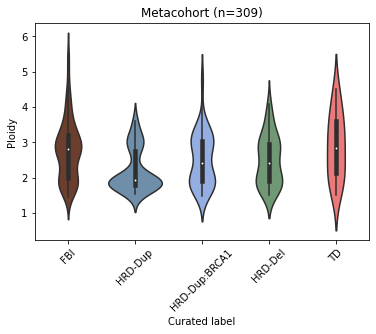

In [26]:
msig_labels = ['FBI', 'HRD-Dup', 'HRD-Dup:BRCA1', 'HRD-Del', 'TD']
msig_colors = {'FBI': '#753924', 'HRD-Dup': '#658FB3', 'HRD-Dup:BRCA1': '#88AAEE', 'HRD-Del': '#6B9E6E', 'TD': '#FF6666'}
sns.violinplot(x='curated label', y='Ploidy', data=msig,
               order=msig_labels, palette=[msig_colors[x] for x in msig_labels])

# Add labels and title
plt.xlabel('Curated label')
plt.xticks(rotation=45)
plt.ylabel('Ploidy')
plt.title(f'Metacohort (n={msig.shape[0]})');

FBI (62, 5) #753924
HRD-Del (29, 5) #6B9E6E
HRD-Dup (38, 5) #658FB3
HRD-Dup:BRCA1 (13, 5) black
TD (18, 5) #FF6666


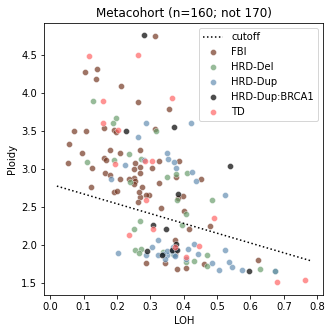

In [263]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(5)
msig_colors = {'FBI':'#753924',
          'HRD-Dup':'#658FB3', 
          'HRD-Dup:BRCA1':'black',
          'HRD-Del':'#6B9E6E',
          'TD':'#FF6666',}
for label, subdf in msig.groupby('curated label'):
    color = msig_colors[label]
    print(label, subdf.shape, color)
    sns.scatterplot(data=subdf, x='LOH', y='Ploidy', color=color, alpha=0.7, ax=ax, label=label)
ax.plot(line_x, line_y, 'k:')
ax.set_xlabel('LOH');
ax.set_title('Metacohort (n=160; not 170)');
legend_order = ['cutoff', 'FBI', 'HRD-Del', 'HRD-Dup', 'HRD-Dup:BRCA1', 'TD']
legend = ax.legend(legend_order)

In [101]:
msig_colors

{'FBI': '#753924',
 'HRD-Dup': '#658FB3',
 'HRD-Dup:BRCA1': '#88AAEE',
 'HRD-Del': '#6B9E6E',
 'TD': '#FF6666'}

FBI (135, 5) #753924
HRD-Del (43, 5) #6B9E6E
HRD-Dup (75, 5) #658FB3
HRD-Dup:BRCA1 (35, 5) #88AAEE
TD (21, 5) #FF6666


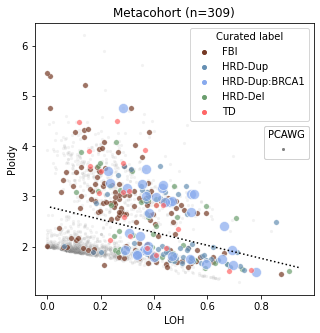

In [116]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(5)
# msig_colors = {'FBI':'#753924',
#           'HRD-Dup':'#658FB3', 
#           'HRD-Dup:BRCA1':'black',
#           'HRD-Del':'#6B9E6E',
#           'TD':'#FF6666',}
p1 = sns.scatterplot(data=pcawg, x='LOH', y='Ploidy', color='grey', alpha=0.1, ax=ax, s=10)
for label, subdf in msig.groupby('curated label'):
    color = msig_colors[label]
    print(label, subdf.shape, color)
    size = 30 if not label.endswith('BRCA1') else 100
    sns.scatterplot(data=subdf, x='LOH', y='Ploidy', color=color, alpha=0.7, ax=ax, label=label, s=size)
ax.plot(line_x, line_y, 'k:')
ax.set_xlabel('LOH');
ax.set_title(f'Metacohort (n={msig.shape[0]})');

handle1 = [plt.plot([], [], color=msig_colors[label], marker="o", ms=4, ls="")[0] for label in msig_colors]
legend1 = ax.legend(handles=handle1, labels=msig_colors.keys(), title="Curated label")
ax.add_artist(legend1);
handle2 = [plt.plot([],[], color="gray", marker="o", ms=2, ls="")[0]]
legend2 = ax.legend(handles=handle2, labels=[''], title="PCAWG", loc=(0.823,0.50))
ax.add_artist(legend2);

In [249]:
msig['curated label'].value_counts().sum()

160

In [259]:
all_wgd = msig['WGD'].sum()
all_wgd_frac = all_wgd / msig.shape[0]
frac = pd.DataFrame(columns=['signature group', 'WGD fraction', 'WGD (real)', 'WGD (expected)'])
for ix, label in enumerate(msig_labels):
    subdf = msig[msig['curated label'] == label]
    msig_count = subdf.shape[0]
    wgd_expected = round(all_wgd_frac * msig_count, 1)
    wgd_count = subdf['WGD'].sum()
    print(label, msig_count, wgd_expected, wgd_count)
    wgs_frac = wgd_count / msig_count
    field = [label, wgs_frac, wgd_count, wgd_expected]
    frac.loc[ix] = field

FBI 62 37.6 53
HRD-Dup 38 23.0 13
HRD-Dup:BRCA1 13 7.9 5
HRD-Del 29 17.6 15
TD 18 10.9 11


In [446]:
all_wgd = msig['WGD'].sum()
all_wgd_frac = all_wgd / msig.shape[0]
frac = pd.DataFrame(columns=['signature group', 'WGD fraction', 'WGD (real)', 'WGD (expected)'])
for ix, label in enumerate(msig_labels):
    subdf = msig[msig['curated label'] == label]
    msig_count = subdf.shape[0]
    wgd_expected = round(all_wgd_frac * msig_count, 2)
    wgd_count = subdf['WGD'].sum()
    print(label, msig_count, wgd_expected, wgd_count)
    wgs_frac = wgd_count / msig_count
    field = [label, wgs_frac, wgd_count, wgd_expected]
    frac.loc[ix] = field

FBI 135 73.83 91
HRD-Dup 75 41.02 23
HRD-Dup:BRCA1 35 19.14 19
HRD-Del 43 23.52 22
TD 21 11.49 14


In [447]:
obs = frac['WGD (real)'].values
exp = frac['WGD (expected)'].values
length = len(obs)
scipy.stats.chisquare(obs, exp)

Power_divergenceResult(statistic=12.556792461452746, pvalue=0.013657237326876756)

In [448]:
frac

,signature group,WGD fraction,WGD (real),WGD (expected)
0,FBI,0.674074,91,73.83
1,HRD-Dup,0.306667,23,41.02
2,HRD-Dup:BRCA1,0.542857,19,19.14
3,HRD-Del,0.511628,22,23.52
4,TD,0.666667,14,11.49


# GMM for WGD event probability

## Pyro version

In [334]:
data = sig.copy()
data.rename(columns={'LOH': 'LOH_fraction', 'Ploidy':'Tumor_ploidy'}, inplace=True)
data = data[['LOH_fraction', 'Tumor_ploidy']]
data.head()

,LOH_fraction,Tumor_ploidy
SA505244,0.323516,2.062922
SA505270,0.485395,2.595106
SA505282,0.165640,2.953009
SA505297,0.575178,1.668616
SA505328,0.272643,1.950251


In [335]:
dist.LogNormal(torch.zeros(2), 1 * torch.ones(2))

LogNormal()

In [362]:
beta = pyro.sample("beta", dist.Dirichlet(torch.ones(2)))
z = pyro.sample("z", dist.Categorical(beta))
mu = pyro.sample("mu", dist.Normal(torch.zeros(2), 10 * torch.ones(2)))
sigma = pyro.sample("sigma", dist.LogNormal(torch.zeros(2), 1 * torch.ones(2)))
pyro.sample("obs", dist.Normal(mu[z], sigma[z]))#, obs=data)

tensor(8.0746)

In [363]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, config_enumerate
from pyro.optim import Adam
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data (assuming it is already in a Pandas DataFrame)
# data = # Your data here as a Pandas DataFrame

# Preprocess data
data['LOH_fraction'] = data['LOH_fraction'].astype(float)
data['Tumor_ploidy'] = data['Tumor_ploidy'].astype(float)

# Split data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data = torch.tensor(train_data[['LOH_fraction', 'Tumor_ploidy']].values, dtype=torch.float32)
test_data = torch.tensor(test_data[['LOH_fraction', 'Tumor_ploidy']].values, dtype=torch.float32)

In [364]:
# Define the Gaussian Mixture Model
# @config_enumerate
def model(data):
    n_samples, _ = data.shape
    n_components = 2

    with pyro.plate("beta_plate", n_components):
        beta = pyro.sample("beta", dist.Dirichlet(torch.ones(n_components)))

    with pyro.plate("mu_plate", n_components):
        mu = pyro.sample("mu", dist.Normal(torch.zeros(2), 10 * torch.ones(2)))

    with pyro.plate("sigma_plate", n_components):
        sigma = pyro.sample("sigma", dist.LogNormal(torch.zeros(2), 1 * torch.ones(2)))

    with pyro.plate("data", n_samples):
        z = pyro.sample("z", dist.Categorical(beta))
        pyro.sample("obs", dist.Normal(mu[z], sigma[z]), obs=data)

In [376]:
sigma_q2 = pyro.param("sigma_q2", torch.ones(n_components, 2), constraint=dist.constraints.positive)
# with pyro.plate("sigma_plate", n_components):
pyro.sample("sigma", dist.LogNormal(torch.zeros(2), sigma_q2))

tensor([[0.1951, 0.2662],
        [0.2087, 1.4138]], grad_fn=<ExpBackward0>)

In [383]:
data_ = torch.Tensor(data.values)
mu = pyro.param("mu_q")
sigma = pyro.param("sigma_q")
alpha = pyro.param("alpha_q")
beta = dist.Dirichlet(alpha).sample()
z_probs = dist.Categorical(beta).log_prob(torch.arange(2)).exp()
likelihoods = dist.Normal(mu, sigma).log_prob(data_.unsqueeze(1)).exp()
wgd_probs = (z_probs * likelihoods).sum(-1)

In [365]:
# Define the guide
def guide(data):
    n_components = 2

    alpha_q = pyro.param("alpha_q", torch.ones(n_components), constraint=dist.constraints.positive)
    with pyro.plate("beta_plate", n_components):
        pyro.sample("beta", dist.Dirichlet(alpha_q))

    mu_q = pyro.param("mu_q", torch.randn(n_components, 2))
    sigma_q = pyro.param("sigma_q", torch.ones(n_components, 2), constraint=dist.constraints.positive)
    with pyro.plate("mu_plate", n_components):
        pyro.sample("mu", dist.Normal(mu_q, sigma_q))

    sigma_q2 = pyro.param("sigma_q2", torch.ones(n_components, 2), constraint=dist.constraints.positive)
    with pyro.plate("sigma_plate", n_components):
        pyro.sample("sigma", dist.LogNormal(torch.zeros(2), sigma_q2))
        
# Posterior predictive
def posterior_predictive(data):
    mu = pyro.param("mu_q")
    sigma = pyro.param("sigma_q")
    alpha = pyro.param("alpha_q")
    beta = dist.Dirichlet(alpha).sample()
    z_probs = dist.Categorical(beta).log_prob(torch.arange(2)).exp()
    likelihoods = dist.Normal(mu, sigma).log_prob(data.unsqueeze(1)).exp()
    wgd_probs = (z_probs * likelihoods).sum(-1)
    return wgd_probs

In [386]:
pyro.render_model(model, model_args=(train_data,))

ValueError: Shape mismatch inside plate('data') at site z dim -1, 136 vs 2
   Trace Shapes:        
    Param Sites:        
   Sample Sites:        
 beta_plate dist     |  
           value   2 |  
       beta dist   2 | 2
           value   2 | 2
   mu_plate dist     |  
           value   2 |  
         mu dist   2 |  
           value   2 |  
sigma_plate dist     |  
           value   2 |  
      sigma dist   2 |  
           value   2 |  
       data dist     |  
           value 136 |  

In [303]:
# Set up the optimizer and inference algorithm
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Training loop
n_steps = 1000
for step in range(n_steps):
    loss = svi.step(train_data)
    if step % 100 == 0:
        print(f"Step {step} - Loss: {loss}")
        
# Estimate WGD probabilities for test data
wgd_probs_test = posterior_predictive(test_data)
print("WGD probabilities for test data:")
print(wgd_probs_test)

RuntimeError: The expanded size of the tensor (136) must match the existing size (2) at non-singleton dimension 0.  Target sizes: [136, 2].  Tensor sizes: [2, 2]
   Trace Shapes:        
    Param Sites:        
   Sample Sites:        
 beta_plate dist     |  
           value   2 |  
       beta dist   2 | 2
           value   2 | 2
   mu_plate dist     |  
           value   2 |  
         mu dist   2 | 2
           value   2 | 2
sigma_plate dist     |  
           value   2 |  
      sigma dist   2 | 2
           value   2 | 2
       data dist     |  
           value 136 |  

## Pyrotch version

In [310]:
import torch
import torch.nn.functional as F
from torch.distributions import MultivariateNormal, Categorical


def initialize_parameters(n_components, n_features):
    pi = torch.ones(n_components) / n_components
    mu = torch.randn(n_components, n_features)
    sigma = torch.stack([torch.eye(n_features) for _ in range(n_components)])
    return pi, mu, sigma


def e_step(data, pi, mu, sigma):
    n_samples, _ = data.shape
    n_components = mu.shape[0]

    log_probs = torch.zeros(n_samples, n_components)
    for i in range(n_components):
        log_probs[:, i] = MultivariateNormal(mu[i], sigma[i]).log_prob(data) + torch.log(pi[i])

    responsibilities = F.softmax(log_probs, dim=1)
    print(responsibilities.shape)
    return responsibilities


def m_step(data, responsibilities):
    n_samples, n_features = data.shape
    n_components = responsibilities.shape[1]

    weights_sum = responsibilities.sum(dim=0)
    pi = weights_sum / n_samples
    mu = responsibilities.T @ data / weights_sum.unsqueeze(-1)
    
    sigma = torch.zeros(n_components, n_features, n_features)
    for i in range(n_components):
        diff = data - mu[i]
        sigma[i] = torch.einsum('ij,ik->jk', responsibilities[:, i] * diff.t(), diff) / weights_sum[i]
    
    return pi, mu, sigma


def em_algorithm(data, n_components, max_iter=100, tol=1e-6):
    n_samples, n_features = data.shape
    pi, mu, sigma = initialize_parameters(n_components, n_features)

    for iteration in range(max_iter):
        responsibilities = e_step(data, pi, mu, sigma)
        pi_new, mu_new, sigma_new = m_step(data, responsibilities)

        if torch.max(torch.abs(pi_new - pi)) < tol and \
           torch.max(torch.abs(mu_new - mu)) < tol and \
           torch.max(torch.abs(sigma_new - sigma)) < tol:
            break

        pi, mu, sigma = pi_new, mu_new, sigma_new

    return pi, mu, sigma


In [312]:
data = sig.copy()
data.rename(columns={'LOH': 'LOH_fraction', 'Ploidy':'Tumor_ploidy'}, inplace=True)
data = data[['LOH_fraction', 'Tumor_ploidy']]
data = torch.tensor(data.values, dtype=torch.float32)
n_components = 2
pi, mu, sigma = em_algorithm(data, n_components)

torch.Size([170, 2])


RuntimeError: einsum(): operands do not broadcast with remapped shapes [original->remapped]: [2, 170]->[170, 1, 2] [170, 2]->[1, 2, 170]